# Submission for Individual Assignment
**NAME:** Lim Wen Mi

**UOW ID:** 7894363

**TASK:** 3 (CNN)

# Initial setup

## Import Libraries

In [2]:
# Required modules for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Common machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Import other required modules
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
from PIL import Image
from google.colab import drive  # For link with google drive

## Mount to dataset path

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the base path to the flowers directory in Google Drive
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/CSCI218/Individual Assignment/flowers'
LABELS = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] # Set sub-folders contain in "flowers"

Mounted at /content/drive


Common RGB values for pure colors:

* Red: [255, 0, 0] (maximum red, no green or blue).
* Green: [0, 255, 0] (maximum green, no red or blue).
* Blue: [0, 0, 255] (maximum blue, no red or green).
* Yellow: [255, 255, 0] (maximum red and green, no blue).
* White: [255, 255, 255] (maximum intensity for all colors).
* Black: [0, 0, 0] (no intensity for any color).

# Pre-processing functions

In [4]:
hist_size = 6

def preprocess_image(path_to_image, img_size=256):
    # Preprocess an image: resize to (128, 128) and normalize pixel values
    img = tf.keras.preprocessing.image.load_img(path_to_image, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

def extract_color_histogram(dataset, hist_size=hist_size):
    # Extract colour histogram features from a dataset of images (joint distribution of pixel intensities)
    col_hist = []
    for img in dataset:
        hist = cv2.calcHist([img], [0, 1, 2], None, (hist_size, hist_size, hist_size), [0, 256, 0, 256, 0, 256])
        col_hist.append(cv2.normalize(hist, None, 0, 1, cv2.NORM_MINMAX).flatten())
    return np.array(col_hist)

def load_dataset(base_path=DRIVE_PATH):
    # Load images and labels from the dataset
    X = []
    Y = []
    for label in LABELS:
        current_size = len(X)
        for img in tqdm(os.listdir(os.path.join(base_path, label))):
            X.append(preprocess_image(os.path.join(base_path, label, img)))
            Y.append(label)
        print(f'Loaded {len(X) - current_size} {label} images')
    return X, Y

def display_random_samples(X, y, samples_per_class=3):
    # Display random sample images from each class
    plt.figure(figsize=(15, 10))
    plt.suptitle('Random Samples from Each Flower Type', fontsize=16)

    for i, label in enumerate(LABELS):
        indices = [idx for idx, class_label in enumerate(y) if class_label == label]
        sample_indices = np.random.choice(indices, samples_per_class, replace=False)

        for j, idx in enumerate(sample_indices):
            plt.subplot(len(LABELS), samples_per_class, i*samples_per_class + j + 1)
            plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
            plt.title(f'{label}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main

## Dataset pre-processing

In [ ]:
# STEP 1. Load image dataset
print("Loading dataset...")
X, y = load_dataset()

# STEP 2. Normalize the images
X = np.array(X) / 255.0 # Convert to numpy array and normalize

print(f"Dataset loaded: {X.shape[0]} images")

# STEP 3. Encode the labels, and then convert to one hot encoding
y = LabelEncoder().fit_transform(y)  # encode labels
y_onehot = to_categorical(y, len(LABELS))  # convert to one-hot encoding with the classes

# STEP 4. Split dataset into train, validation, and test
# Set the split to achieve 60% train, 20% validation and 20% test
# Split 60% for training & 40% for validation + test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.4, random_state=42)
# Split validation + test with 0.5, hence 40/2 => 20% for test & 20% for validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# STEP 5. (Optional) Create a data generator with augmentation techniques, and then fit to the training data
data_generator = ImageDataGenerator(
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=6,  # randomly rotate images in the range (degrees, 0 to 10)
                                    zoom_range=0.2,  # randomly zoom image
                                    width_shift_range=0.2,  # randomly shift images horizontally
                                    height_shift_range=0.2,  # randomly shift images vertically
                                    horizontal_flip=True,  # randomly flip images
                                    vertical_flip=False,  # no vertical flip
                                    fill_mode='nearest',
                                    )

Loading dataset...


100%|██████████| 764/764 [00:00<00:00, 1008.31it/s]


Loaded 764 daisy images


100%|██████████| 1052/1052 [00:01<00:00, 967.57it/s]


Loaded 1052 dandelion images


100%|██████████| 784/784 [00:00<00:00, 984.11it/s] 


Loaded 784 rose images


100%|██████████| 733/733 [00:00<00:00, 811.23it/s]


Loaded 733 sunflower images


100%|██████████| 984/984 [00:01<00:00, 910.23it/s] 


Loaded 984 tulip images
Dataset loaded: 4317 images


## CNN model setup and training

C:\Users\jayzw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_178 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_178               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_179               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_180               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_71 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,269 (6.48 MB)

 Trainable params: 1,699,269 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\jayzw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.2453 - loss: 1.6018 - val_accuracy: 0.3036 - val_loss: 1.5129 - learning_rate: 1.0000e-04
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.3424 - loss: 1.4887 - val_accuracy: 0.4206 - val_loss: 1.3612 - learning_rate: 1.0000e-04
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.3733 - loss: 1.4008 - val_accuracy: 0.4484 - val_loss: 1.2441 - learning_rate: 1.0000e-04
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4381 - loss: 1.2962 - val_accuracy: 0.4623 - val_loss: 1.2066 - learning_rate: 1.0000e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.4683 - loss: 1.2593 - val_accuracy: 0.4762 - val_loss: 1.1852 - learning_rate: 1.0000e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.4618 - loss: 1.2444 - val_accuracy: 0.5064 - val_loss: 1.1508 - learning_rate: 1.0000e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - 

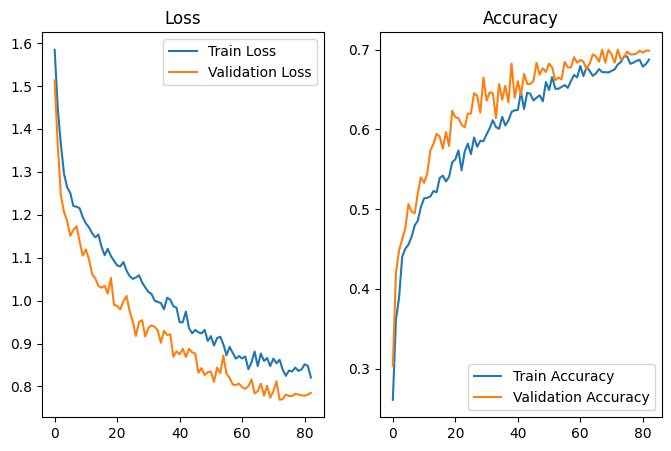

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7102 - loss: 0.7513
Test Accuracy: 0.7130


In [ ]:
# STEP 6. Create CNN and then summarize the model
Batch_size = int(64)
Epochs = int(100)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(LABELS), activation='softmax')
])
model.summary()

# STEP 7. Define optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


if __name__ == '__main__':
    # STEP 8. Train the CNN model

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,         # Stop after 10 epochs without improvement
        restore_best_weights=True  # Restore the best model weights
    )

    # Reduce the learning rate
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # Monitor validation loss
        factor=0.2,          # Reduce learning rate by a factor of 0.2
        patience=5,          # Wait for 5 epochs without improvement
        min_lr=1e-6          # Minimum learning rate
    )

    start_time = timer()
    history = model.fit(data_generator.flow(X_train, y_train, batch_size = Batch_size),
                        epochs = Epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    test_time = timer() - start_time

    # Save the model
    model.save('cnn_model.hdf5')

    # STEP 9. Plot training loss and accuracy
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # STEP 10. Evaluate the CNN on the test dataset
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")


## Classification Metrics

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Metrics:
Accuracy: 0.7130
Precision: 0.7140
Recall: 0.7130
F1-score: 0.7097
Average prediction time per image: 0.8648 seconds


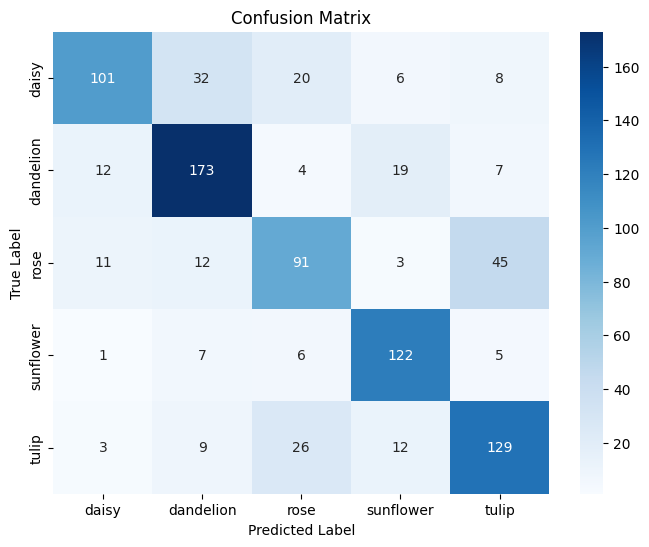

In [ ]:
# STEP 11. Classification metrics
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1) # Convert y_test from one-hot encoded to class indices

accuracy = accuracy_score(y_test_classes, Y_pred_classes)
precision = precision_score(y_test_classes, Y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, Y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, Y_pred_classes, average='weighted')

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Average prediction time per image: {(test_time/len(X_test)):.4f} seconds")

# STEP 12. Confusion matrix
cm = confusion_matrix(y_test_classes, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Analyzation

In [ ]:
# STEP 13. Show correctly/incorrectly classified images
def display_classified_images(X_test, y_test, y_pred, correct=True, num_images=5):
    indices = [i for i in range(len(y_test)) if (y_test[i] == y_pred[i]) == correct]
    if len(indices) < num_images:
        num_images = len(indices)
    sample_indices = np.random.choice(indices, num_images, replace=False)

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        title = f"Pred: {LABELS[y_pred[idx]]}\nActual: {LABELS[y_test[idx]]}"
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Display correctly/incorrectly classified images

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Correctly Classified Images:


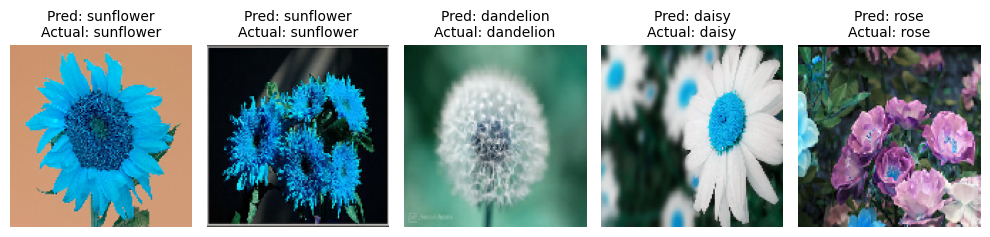

Misclassified Images:


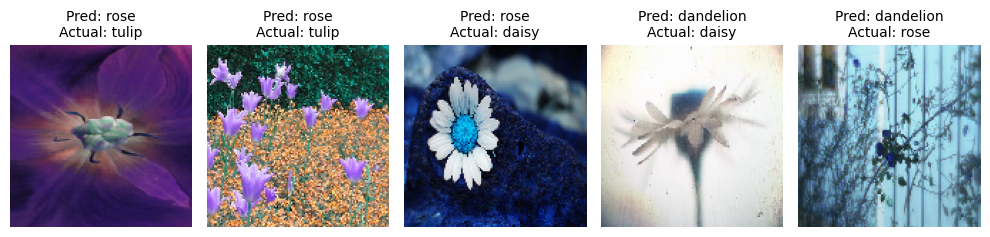


Analysis of Common Misclassifications:
rose mistaken for tulip: 45 times
daisy mistaken for dandelion: 32 times
tulip mistaken for rose: 26 times
daisy mistaken for rose: 20 times
dandelion mistaken for sunflower: 19 times


In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_test_classes = np.argmax(y_test, axis=1)  # True class indices

print("Correctly Classified Images:")
display_classified_images(X_test, y_test_classes, y_pred_classes, correct=True, num_images=5)

print("Misclassified Images:")
display_classified_images(X_test, y_test_classes, y_pred_classes, correct=False, num_images=5)

# STEP 13.1. Analysis clasification
print("\nAnalysis of Common Misclassifications:")
incorrect = np.where(y_pred_classes != y_test_classes)[0]  # Find indices of misclassified examples
confusion_pairs = [(y_test_classes[i], y_pred_classes[i]) for i in incorrect]  # Extract true and predicted labels for misclassified samples

# Count occurrences of each misclassification pair
common_confusions = {}
for true, pred in confusion_pairs:
    pair = (LABELS[true], LABELS[pred]) # Maps the numerical indices to class name
    common_confusions[pair] = common_confusions.get(pair, 0) + 1

# Sort and print the top 5 most common misclassifications
sorted_confusions = sorted(common_confusions.items(), key=lambda x: x[1], reverse=True)
for (true, pred), count in sorted_confusions[:5]:
    print(f"{true} mistaken for {pred}: {count} times")